# Masterclass: Feature Engineering Avanzato
**Professore:** Gemini AI

Il Feature Engineering è l'arte di trasformare i dati grezzi in rappresentazioni che espongono meglio il problema sottostante ai modelli predittivi. In questa lezione vedremo:
1. **Gestione della Skewness:** Trasformazione Logaritmica.
2. **Domain Knowledge:** Creazione di variabili basate sulla logica di settore.
3. **Brute Force:** Generazione sistematica di combinazioni matematiche.

--- 
## 1. Trattamento della Skewness (Asimmetria)
### Teoria
Molte variabili reali (come il reddito o il prezzo degli immobili) presentano una **distribuzione asimmetrica positiva** (long tail). Gli algoritmi basati su gradienti e i modelli lineari faticano con questi dati perché gli outlier nella coda lunga dominano la funzione di costo.

La **Trasformazione Logaritmica** è la soluzione standard: comprimendo i valori grandi e dilatando quelli piccoli, rende la distribuzione simile a una **Normale (Gaussiana)**, facilitando la convergenza del modello.

Formula: $$y = \log(x + 1)$$

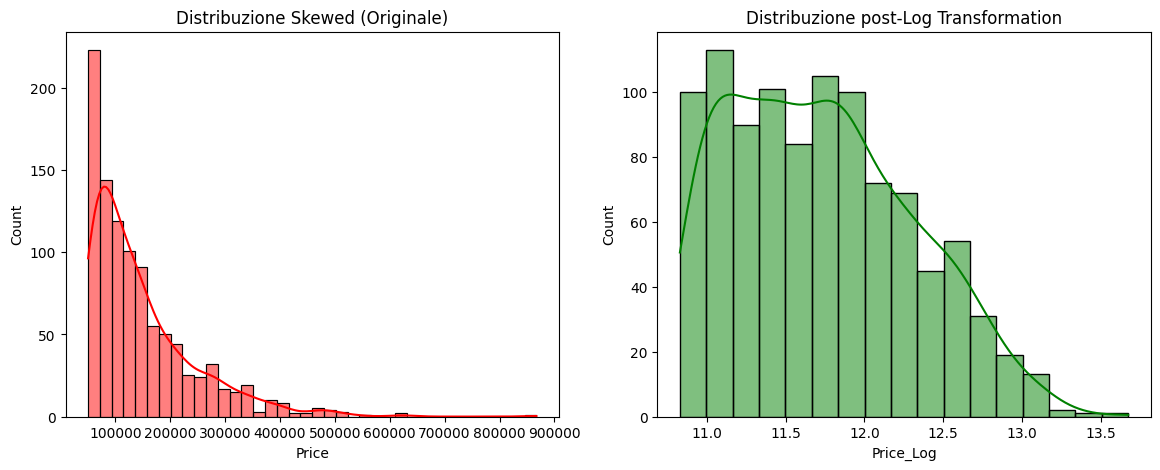

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generazione di una distribuzione fortemente asimmetrica (es. Prezzo Case)
np.random.seed(42)
prices = np.random.exponential(scale=100000, size=1000) + 50000
df = pd.DataFrame({'Price': prices})

plt.figure(figsize=(14, 5))

# Prima della trasformazione
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True, color='red')
plt.title("Distribuzione Skewed (Originale)")

# Dopo la trasformazione Logaritmica
df['Price_Log'] = np.log1p(df['Price'])
plt.subplot(1, 2, 2)
sns.histplot(df['Price_Log'], kde=True, color='green')
plt.title("Distribuzione post-Log Transformation")

plt.show()

--- 
## 2. Feature Engineering: Domain Knowledge
### Teoria
La conoscenza del dominio ci permette di creare feature che hanno un significato fisico o economico reale. Spesso, il **rapporto** o la **differenza** tra due variabili è molto più predittivo della variabile singola.

Esempi comuni:
- **Immobiliare:** Prezzo per metro quadro.
- **Finanza:** Rapporto debito/reddito.
- **Sanità:** BMI (Peso / Altezza²).

In [2]:
# Simulazione di dati immobiliari
df['MetriQuadri'] = np.random.normal(80, 30, 1000).clip(30, 300)
df['Stanze'] = np.random.randint(1, 6, 1000)
df['AnnoCostruzione'] = np.random.randint(1950, 2024, 1000)

# --- Creazione Feature di Settore ---

# 1. Prezzo al MQ (Molto utile per normalizzare il valore)
df['Price_per_SQM'] = df['Price'] / df['MetriQuadri']

# 2. Dimensione media delle stanze
df['Avg_Room_Size'] = df['MetriQuadri'] / df['Stanze']

# 3. Età dell'immobile (Differenza temporale rispetto ad oggi)
df['Property_Age'] = 2026 - df['AnnoCostruzione']

print("Feature basate su Domain Knowledge generate.")
df[['Price', 'MetriQuadri', 'Price_per_SQM', 'Property_Age']].head()

Feature basate su Domain Knowledge generate.


,Price,MetriQuadri,Price_per_SQM,Property_Age
0,96926.808998,85.331030,1135.891703,23
1,351012.143092,39.939669,8788.559089,57
2,181674.569355,91.405936,1987.557682,58
3,141294.255378,98.317572,1437.121076,11
4,66962.487046,96.793713,691.806158,47


--- 
## 3. Feature Engineering: Brute Force
### Teoria
Quando la logica di settore non basta, usiamo il **Brute Force**. Questo approccio genera sistematicamente tutte le combinazioni matematiche possibili tra le variabili. 

Sebbene crei molta ridondanza, può rivelare relazioni non lineari (es. interazioni) che l'algoritmo non riuscirebbe a trovare da solo. Le operazioni includono:
- **Somma/Differenza:** Effetto accumulo o gap.
- **Moltiplicazione:** Effetti di interazione ($x_1 \cdot x_2$).
- **Divisione:** Rapporti e proporzioni.
- **Trasformazioni:** Logaritmi e radici.

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# Selezioniamo due feature per il brute force per evitare esplosione dimensionale
features_to_combine = ['MetriQuadri', 'Stanze']

# 1. Approccio Manuale: Somma, Differenza, Moltiplicazione, Divisione
df['BF_Sum'] = df['MetriQuadri'] + df['Stanze']
df['BF_Diff'] = df['MetriQuadri'] - df['Stanze']
df['BF_Mult'] = df['MetriQuadri'] * df['Stanze']
df['BF_Div'] = df['MetriQuadri'] / (df['Stanze'] + 0.1) # evitiamo div per zero

# 2. Approccio Sistematico: Polynomial Features (Grado 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(df[features_to_combine])
poly_cols = poly.get_feature_names_out(features_to_combine)

df_poly = pd.DataFrame(poly_data, columns=poly_cols)

print("Esempi di Feature Brute Force (Polinomiali):")
display(df_poly.head())

print("\nEsempi di Feature Brute Force (Matematiche Manuali):")
display(df[['BF_Sum', 'BF_Diff', 'BF_Mult', 'BF_Div']].head())

Esempi di Feature Brute Force (Polinomiali):


,MetriQuadri,Stanze,MetriQuadri^2,MetriQuadri Stanze,Stanze^2
0,85.331030,1.0,7281.384686,85.331030,1.0
1,39.939669,1.0,1595.177179,39.939669,1.0
2,91.405936,5.0,8355.045050,457.029678,25.0
3,98.317572,5.0,9666.345034,491.587862,25.0
4,96.793713,1.0,9369.022961,96.793713,1.0



Esempi di Feature Brute Force (Matematiche Manuali):


,BF_Sum,BF_Diff,BF_Mult,BF_Div
0,86.331030,84.331030,85.331030,77.573664
1,40.939669,38.939669,39.939669,36.308790
2,96.405936,86.405936,457.029678,17.922732
3,103.317572,93.317572,491.587862,19.277955
4,97.793713,95.793713,96.793713,87.994285


--- 
## 4. Considerazioni Finali e Rischio
Il Feature Engineering Brute Force è un'arma a doppio taglio. 
- **Pro:** Può migliorare drasticamente l'accuratezza catturando interazioni complesse.
- **Contro:** Causa la **Curse of Dimensionality** (maledizione della dimensionalità). Più variabili creiamo, più il modello rischia l'**Overfitting**.

**Best Practice:** Dopo il Brute Force, applicare sempre una **Feature Selection** (es. LASSO o importanza delle feature di XGBoost) per eliminare le combinazioni che aggiungono solo rumore.

In [4]:
df.describe()

,Price,Price_Log,MetriQuadri,Stanze,AnnoCostruzione,Price_per_SQM,Avg_Room_Size,Property_Age,BF_Sum,BF_Diff,BF_Mult,BF_Div
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,147250.594797,11.723901,83.451524,3.007000,1987.204000,2074.661141,38.340612,38.796000,86.458524,80.444524,251.648631,36.033012
std,97250.988616,0.576075,28.581573,1.434925,21.209768,1832.450997,29.200579,21.209768,28.642391,28.592729,153.669936,26.255761
min,50464.278407,10.829041,30.000000,1.000000,1950.000000,341.403377,6.000000,3.000000,31.000000,25.000000,30.000000,5.882353
25%,76915.652932,11.250471,63.076374,2.000000,1969.000000,945.947289,18.452265,19.750000,65.953821,59.577415,120.000000,18.055213
50%,118678.261725,11.684180,82.526418,3.000000,1988.000000,1459.786754,27.485760,38.000000,85.723702,80.113799,223.289292,26.808401
75%,186383.020860,12.135564,102.188951,4.000000,2006.250000,2565.440936,47.875402,57.000000,105.683755,99.052716,359.933736,45.136938
max,867244.559782,13.673077,175.793227,5.000000,2023.000000,15535.413877,156.745979,76.000000,180.793227,170.793227,878.966135,142.496344


In [6]:
df_poly.describe()

,MetriQuadri,Stanze,MetriQuadri^2,MetriQuadri Stanze,Stanze^2
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,83.451524,3.007000,7780.246365,251.648631,11.099000
std,28.581573,1.434925,5019.208677,153.669936,8.749615
min,30.000000,1.000000,900.000000,30.000000,1.000000
25%,63.076374,2.000000,3978.628939,120.000000,4.000000
50%,82.526418,3.000000,6810.613034,223.289292,9.000000
75%,102.188951,4.000000,10442.583550,359.933736,16.000000
max,175.793227,5.000000,30903.258672,878.966135,25.000000
